In [1]:
import kagglehub
path = kagglehub.dataset_download("bappekim/air-pollution-in-seoul")
print("Path to dataset files:", path)

100%|██████████| 19.7M/19.7M [00:01<00:00, 18.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/bappekim/air-pollution-in-seoul/versions/2


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import cdist
import itertools
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# EDA

In [3]:
df = pd.read_csv(os.path.join(path, "AirPollutionSeoul/Measurement_summary.csv"))
df_station = pd.read_csv(os.path.join(path, "AirPollutionSeoul/Original Data/Measurement_station_info.csv"))

df.describe()

,Station code,Latitude,Longitude,SO2,NO2,O3,CO,PM10,PM2.5
count,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000,647511.000000
mean,113.000221,37.553484,126.989340,-0.001795,0.022519,0.017979,0.509197,43.708051,25.411995
std,7.211315,0.053273,0.078790,0.078832,0.115153,0.099308,0.405319,71.137342,43.924595
min,101.000000,37.452357,126.835151,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,107.000000,37.517528,126.927102,0.003000,0.016000,0.008000,0.300000,22.000000,11.000000
50%,113.000000,37.544962,127.004850,0.004000,0.025000,0.021000,0.500000,35.000000,19.000000
75%,119.000000,37.584848,127.047470,0.005000,0.038000,0.034000,0.600000,53.000000,31.000000
max,125.000000,37.658774,127.136792,3.736000,38.445000,33.600000,71.700000,3586.000000,6256.000000


In [4]:
cols = ["SO2", "NO2", "O3", "CO", "PM10", "PM2.5"]
negative_counts_real = ((df[cols] < 0) & (df[cols] != -1)).sum()
print(negative_counts_real)

SO2      0
NO2      0
O3       0
CO       0
PM10     0
PM2.5    0
dtype: int64


#### The dataset has no negative values.
The dataset writes missing data as -1. Excluding -1, the above shows that the dataset has no negative values. Since -1 is treated as missing data in this dataset, therefore the dataset has no negative values.

In [5]:
negative_counts = (df[cols] < 0).sum()
print("missing data")
print(negative_counts)

missing data
SO2      3976
NO2      3834
O3       4059
CO       4036
PM10     3962
PM2.5    3973
dtype: int64


#### The dataset has some missing data.
The dataset writes missing data as -1.

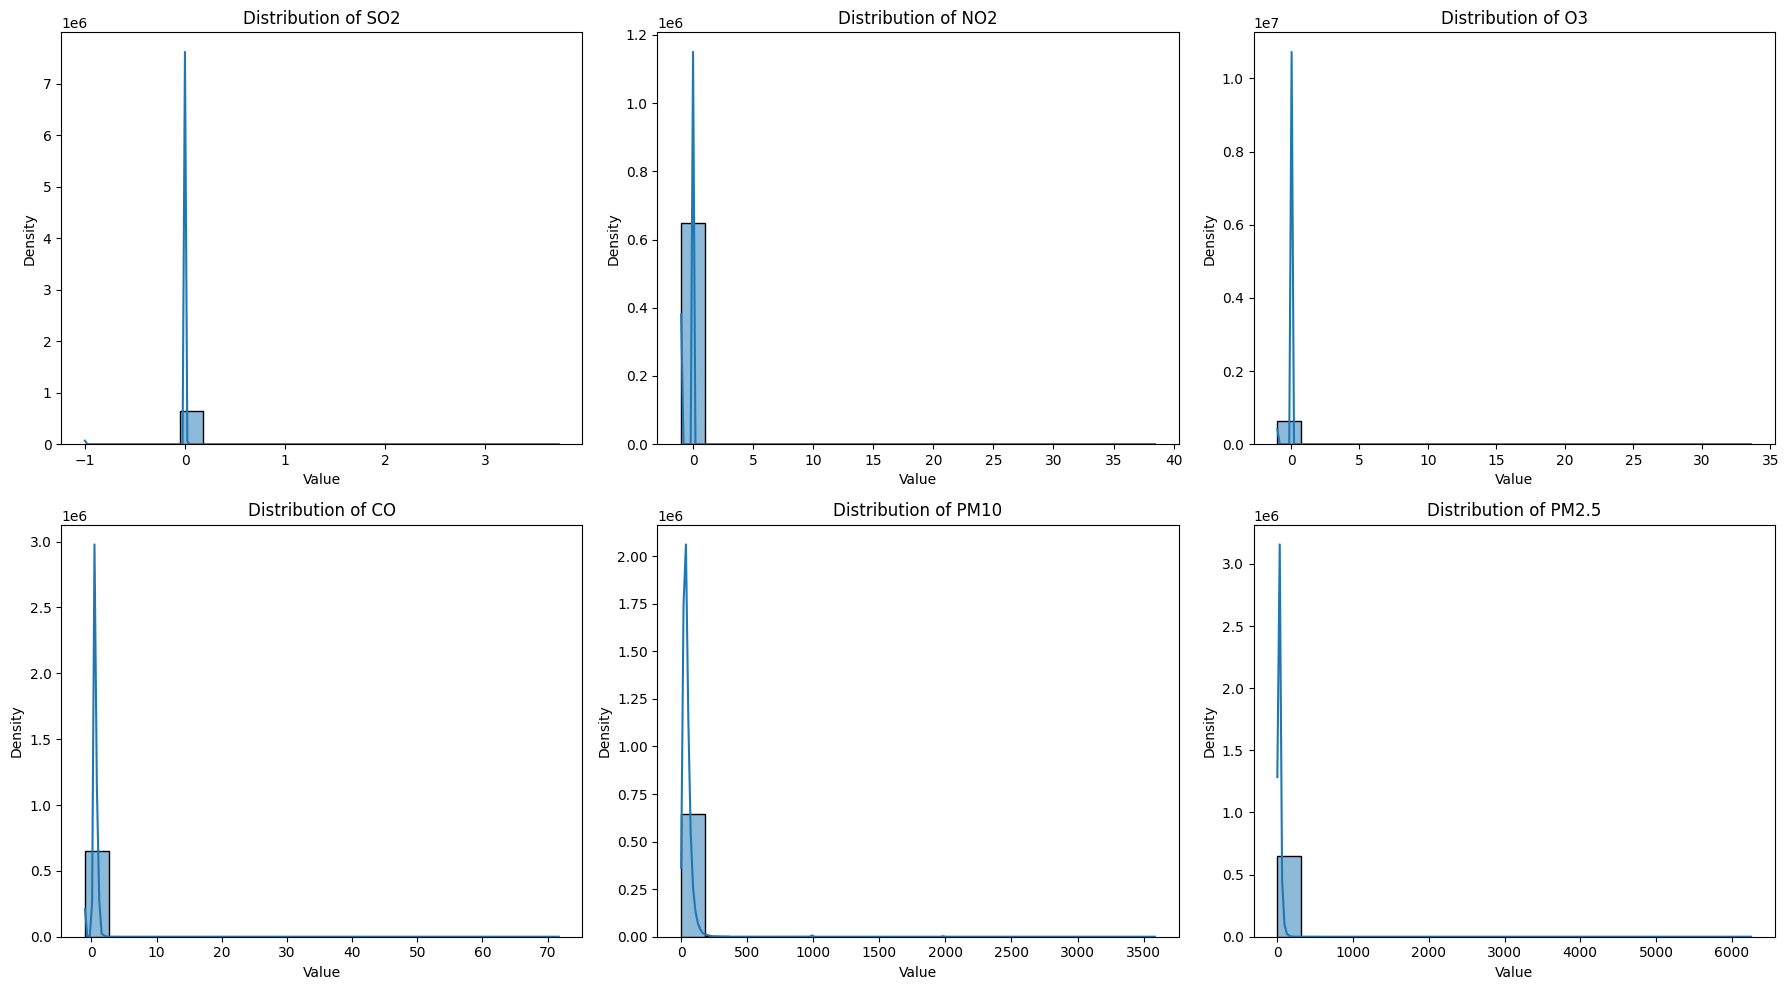

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

cols = ["SO2", "NO2", "O3", "CO", "PM10", "PM2.5"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, col in zip(axes.flatten(), cols):
    sns.histplot(df[col], kde=True, bins=20, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.show()


#### The average and maximum value of PM10 and PM2.5 is quite far apart.

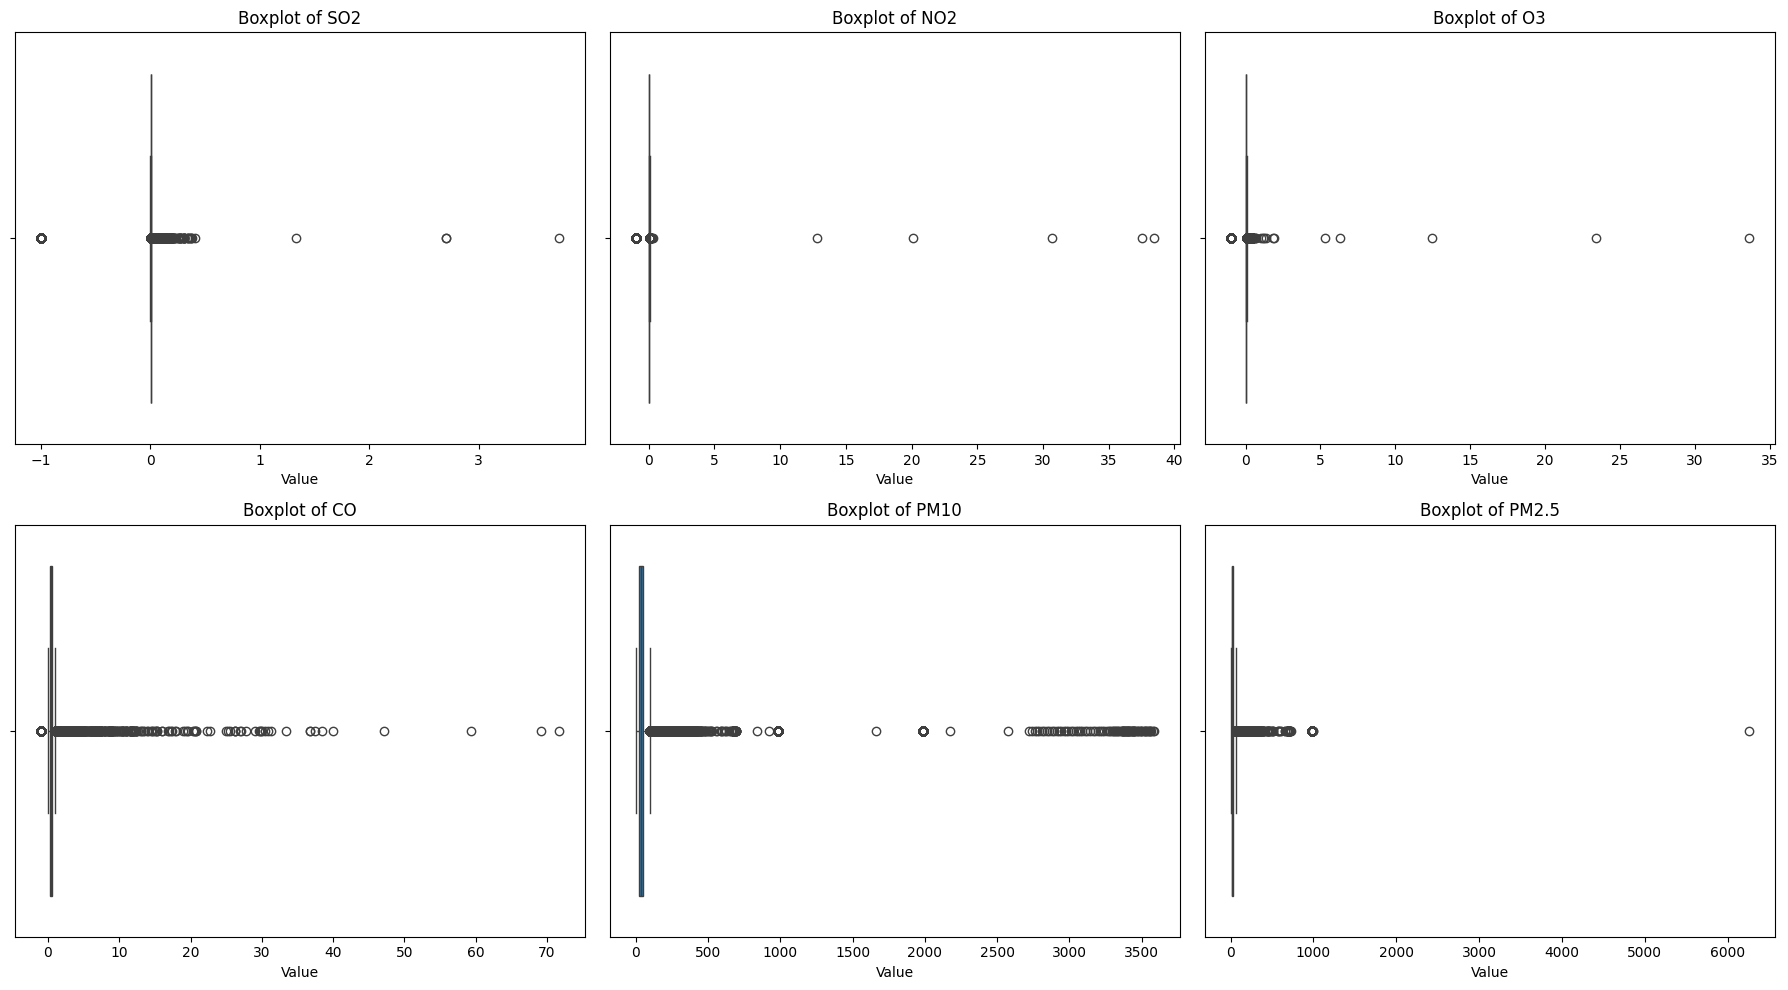

In [7]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, col in zip(axes.flatten(), cols):
    sns.boxplot(x=df[col], ax=ax)
    ax.set_title(f'Boxplot of {col}')
    ax.set_xlabel('Value')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()


#### There are many outliers for CO, PM10, and PM2.5

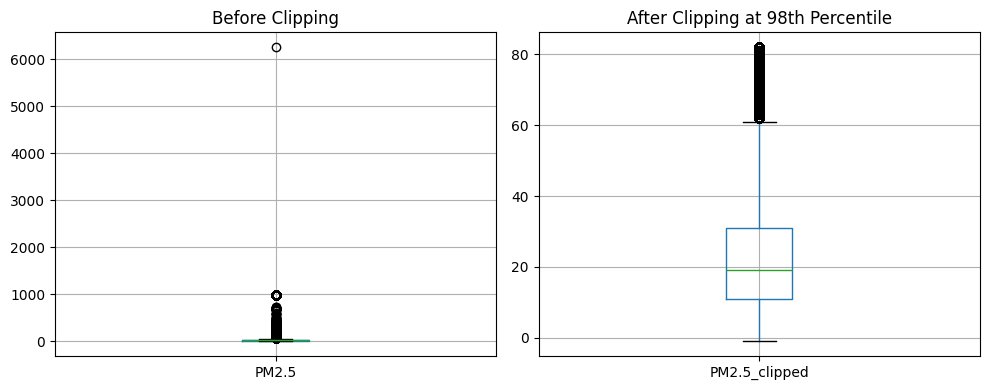

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
df[['PM2.5']].boxplot()
plt.title("Before Clipping")

upper_limit = df['PM2.5'].quantile(0.98)
df['PM2.5_clipped'] = df['PM2.5'].clip(upper=upper_limit)

plt.subplot(1,2,2)
df[['PM2.5_clipped']].boxplot()
plt.title("After Clipping at 98th Percentile")

plt.tight_layout()
plt.show()

# Preprocessing

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
keep_stations_codes = [101, 102, 105, 106, 107, 109, 111, 112, 113, 119, 120, 121, 122]

def preprocess_seoul_data(df, scalers, look_back_window=24, target_stations=None, train_split=0.8):
    if target_stations is not None:
        df = df[df['Station code'].isin(target_stations)].copy()

    cols_to_clean = ['NO2', 'O3', 'CO', 'SO2', 'PM10', 'PM2.5']
    for col in cols_to_clean:
        df[col] = df[col].replace(-1, np.nan)

    df['Measurement date'] = pd.to_datetime(df['Measurement date'])
    full_time_range = pd.date_range(start=df['Measurement date'].min(), end=df['Measurement date'].max(), freq='h')

    time_df = pd.DataFrame({'Measurement date': full_time_range})
    time_df['hour'] = time_df['Measurement date'].dt.hour
    time_df['month'] = time_df['Measurement date'].dt.month

    time_df['hour_sin'] = np.sin(2 * np.pi * time_df['hour'] / 24.0)
    time_df['hour_cos'] = np.cos(2 * np.pi * time_df['hour'] / 24.0)
    time_df['month_sin'] = np.sin(2 * np.pi * time_df['month'] / 12.0)
    time_df['month_cos'] = np.cos(2 * np.pi * time_df['month'] / 12.0)

    feature_cols = ['NO2', 'O3', 'CO', 'SO2', 'PM10', 'PM2.5']
    time_cols = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']

    processed_features = []

    n_total_steps = len(full_time_range)
    train_size = int(n_total_steps * train_split)

    for feat in feature_cols:
        pivot = df.pivot_table(index='Measurement date', columns='Station code', values=feat)
        pivot = pivot.reindex(full_time_range)

        pivot = pivot.interpolate(method='linear', limit_direction='both').bfill().ffill()

        train_data_values = pivot.values[:train_size]
        upper_limit = np.nanpercentile(train_data_values, 98)
        pivot_clipped = pivot.clip(upper=upper_limit)

        scaler = MinMaxScaler()

        scaler.fit(pivot_clipped.values[:train_size])

        norm = scaler.transform(pivot_clipped.values)

        scalers[feat] = scaler
        processed_features.append(norm)

    if not processed_features:
        raise ValueError("No features were processed. Check input dataframe.")

    num_stations = processed_features[0].shape[1]
    for t_col in time_cols:
        t_val = time_df[t_col].values.reshape(-1, 1)
        processed_features.append(np.tile(t_val, (1, num_stations)))

    data_block = np.stack(processed_features, axis=-1)

    X, Y = [], []
    t_idxs = [0, 1, 2, 3, 4, 5]

    for i in range(len(data_block) - look_back_window - 1):
        X.append(data_block[i:i+look_back_window])
        Y.append(data_block[i+look_back_window, :, t_idxs])

    return torch.FloatTensor(np.array(X)), torch.FloatTensor(np.array(Y))

In [6]:
SEQ_LEN = 24
NUM_NODES = len(keep_stations_codes)
NUM_FEATURES = 10
TARGET_DIM = 6
EPOCHS = 10
TUNE_EPOCHS = 5
FINAL_EPOCHS = 10

# TARGET_COLS = ['NO2', 'O3', 'CO', 'SO2', 'PM10', 'PM2.5']
# target_indices = [0, 1, 2, 3, 4, 5]

In [14]:
scalers = {}
X, Y = preprocess_seoul_data(df, scalers, look_back_window=SEQ_LEN, target_stations=keep_stations_codes)

# Adjacency Matrix

In [7]:
def build_distance_adjacency(stations_df, sigma_scale=0.5, threshold=0.5):
    coords = stations_df[['Latitude', 'Longitude']].values
    dists = cdist(coords, coords, metric='euclidean')

    non_zero_dists = dists[dists > 0]
    sigma = np.std(non_zero_dists) * sigma_scale

    adj = np.exp(- (dists ** 2) / (2 * sigma ** 2))

    adj[adj < threshold] = 0

    np.fill_diagonal(adj, 1.0)

    row_sum = np.sum(adj, axis=1)
    row_sum[row_sum == 0] = 1.0
    adj = adj / row_sum[:, np.newaxis]

    return torch.FloatTensor(adj)

def visualize_adjacency_matrix(adj_tensor, station_labels):
    if torch.is_tensor(adj_tensor):
        adj_matrix_np = adj_tensor.cpu().numpy()
    else:
        adj_matrix_np = adj_tensor
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        adj_matrix_np,
        annot=True,
        fmt=".2f",
        cmap="viridis",
        xticklabels=station_labels,
        yticklabels=station_labels,
        cbar_kws={'label': 'Influence Weight'}
    )
    plt.title("Spatial Graph Connections (Normalized Adjacency Matrix)")
    plt.xlabel("Target District (Influenced By)")
    plt.ylabel("Source District (Influencing)")
    plt.xticks(rotation=45)
    plt.show()

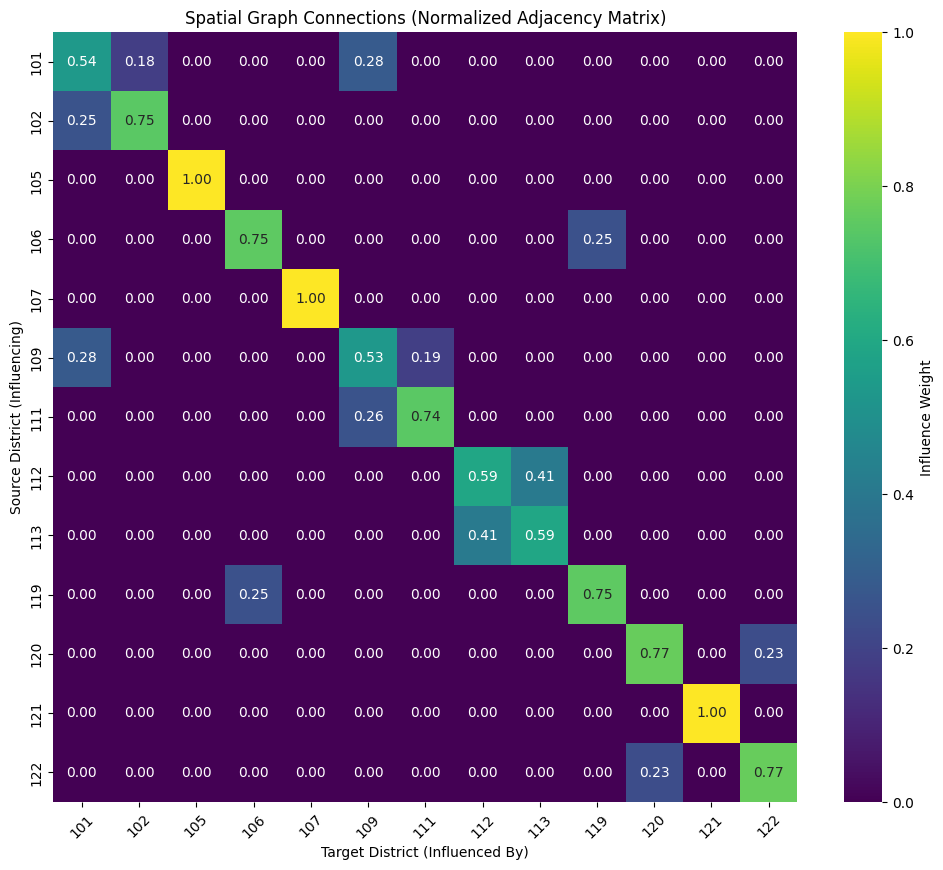

In [10]:
df_station_filtered = df_station[df_station['Station code'].isin(keep_stations_codes)].reset_index(drop=True)
adj_matrix = build_distance_adjacency(df_station_filtered, sigma_scale=0.5, threshold=0.3)
adj_matrix = adj_matrix.to(device)
visualize_adjacency_matrix(adj_matrix, keep_stations_codes)

In [15]:
torch.save(adj_matrix, "adj_matrix.pt")

# Model

In [11]:
class GraphConv(nn.Module):
    def __init__(self, in_features, out_features, adj_matrix):
        super(GraphConv, self).__init__()
        self.adj = adj_matrix
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x):
        out = torch.bmm(self.adj.unsqueeze(0).repeat(x.size(0), 1, 1), x)
        return self.fc(out)

class TGCN(nn.Module):
    def __init__(self, num_nodes, num_features, hidden_dim, output_dim, adj_matrix, dropout_prob=0.0):
        super(TGCN, self).__init__()
        self.gc1 = GraphConv(num_features, hidden_dim, adj_matrix)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        B, T, N, F = x.shape
        out = []
        for t in range(T):
            xt = x[:, t, :, :]
            xt = torch.relu(self.gc1(xt))
            out.append(xt)
        out = torch.stack(out, dim=1)
        out = out.transpose(1, 2)
        out = out.reshape(B * N, T, -1)
        out, _ = self.gru(out)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        out = out.view(B, N, -1)
        return out

# Training

In [15]:
total_seq = X.size(0)
train_size = int(0.8 * total_seq)
val_size = int(0.1 * total_seq)
x_train_tune = X[:train_size]
y_train_tune = Y[:train_size]
x_val_tune = X[train_size:train_size + val_size]
y_val_tune = Y[train_size:train_size + val_size]

test_start_idx = train_size + val_size
x_test = X[test_start_idx:]
y_test = Y[test_start_idx:]

## Hyperparameter Tuning

In [18]:
param_grid = {
    'batch_size': [32, 64],
    'hidden_dim': [32, 64, 128],
    'learning_rate': [0.001, 0.0005, 0.0001],
    'dropout': [0.0, 0.1]
}
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
best_val_loss = float('inf')
best_params = None

for params in combinations:
    print(f"Testing: {params}")
    train_ds = TensorDataset(x_train_tune, y_train_tune)
    train_loader = DataLoader(train_ds, batch_size=params['batch_size'], shuffle=True)
    val_ds = TensorDataset(x_val_tune, y_val_tune)
    val_loader = DataLoader(val_ds, batch_size=params['batch_size'])

    model = TGCN(NUM_NODES, NUM_FEATURES, params['hidden_dim'], TARGET_DIM, adj_matrix, params['dropout']).to(device)
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss()

    for epoch in range(TUNE_EPOCHS):
        model.train()
        train_loss = 0
        for bx, by in train_loader:
            bx, by = bx.to(device), by.to(device)

            if by.shape[1] == TARGET_DIM and by.shape[2] == NUM_NODES:
                by = by.transpose(1, 2)

            optimizer.zero_grad()
            pred = model(bx)
            loss = criterion(pred, by)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for bx, by in val_loader:
            bx, by = bx.to(device), by.to(device)

            if by.shape[1] == TARGET_DIM and by.shape[2] == NUM_NODES:
                by = by.transpose(1, 2)

            pred = model(bx)
            loss = criterion(pred, by)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f"Final Val Loss: {val_loss:.5f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_params = params
print(f"Best Params: {best_params}, Best Val Loss: {best_val_loss:.5f}")

Testing: {'batch_size': 32, 'hidden_dim': 32, 'learning_rate': 0.001, 'dropout': 0.0}
Final Val Loss: 0.00531
Testing: {'batch_size': 32, 'hidden_dim': 32, 'learning_rate': 0.001, 'dropout': 0.1}
Final Val Loss: 0.00534
Testing: {'batch_size': 32, 'hidden_dim': 32, 'learning_rate': 0.0005, 'dropout': 0.0}
Final Val Loss: 0.00537
Testing: {'batch_size': 32, 'hidden_dim': 32, 'learning_rate': 0.0005, 'dropout': 0.1}
Final Val Loss: 0.00536
Testing: {'batch_size': 32, 'hidden_dim': 32, 'learning_rate': 0.0001, 'dropout': 0.0}
Final Val Loss: 0.00882
Testing: {'batch_size': 32, 'hidden_dim': 32, 'learning_rate': 0.0001, 'dropout': 0.1}
Final Val Loss: 0.00841
Testing: {'batch_size': 32, 'hidden_dim': 64, 'learning_rate': 0.001, 'dropout': 0.0}
Final Val Loss: 0.00519
Testing: {'batch_size': 32, 'hidden_dim': 64, 'learning_rate': 0.001, 'dropout': 0.1}
Final Val Loss: 0.00528
Testing: {'batch_size': 32, 'hidden_dim': 64, 'learning_rate': 0.0005, 'dropout': 0.0}
Final Val Loss: 0.00532
Testi

## Final Training

In [16]:
best_params = {'batch_size': 64, 'hidden_dim': 128, 'learning_rate': 0.001, 'dropout': 0.1} #taken from Hyperparameter Tuning
x_final_train = torch.cat([x_train_tune, x_val_tune], dim=0)
y_final_train = torch.cat([y_train_tune, y_val_tune], dim=0)

final_dataset = TensorDataset(x_final_train, y_final_train)
final_loader = DataLoader(final_dataset, batch_size=best_params['batch_size'], shuffle=True)

final_model = TGCN(
    NUM_NODES,
    NUM_FEATURES,
    best_params['hidden_dim'],
    TARGET_DIM,
    adj_matrix,
    best_params['dropout']
).to(device)

In [17]:
!pip install torchviz

In [18]:
print(final_model)

TGCN(
  (gc1): GraphConv(
    (fc): Linear(in_features=10, out_features=128, bias=True)
  )
  (gru): GRU(128, 128, batch_first=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=6, bias=True)
)


In [ ]:
from torchviz import make_dot

dummy_input = torch.randn(1, SEQ_LEN, NUM_NODES, NUM_FEATURES).to(device)

output = final_model(dummy_input)

dot = make_dot(output, params=dict(final_model.named_parameters()))
dot.format = 'png'
dot.render("tgcn_architecture")

'tgcn_architecture.png'

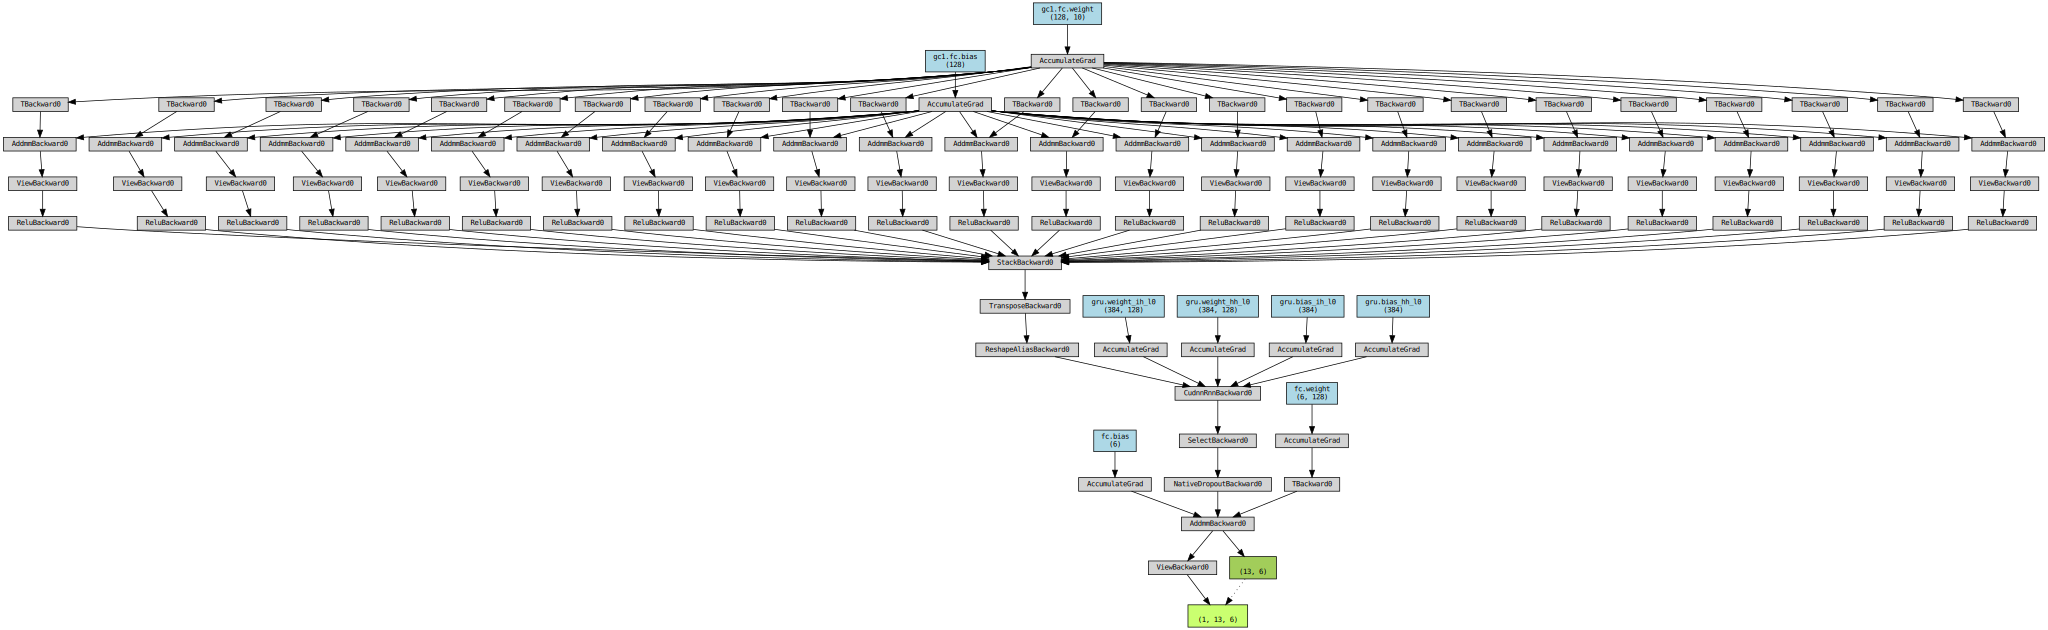

In [20]:
dot

In [ ]:
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss()

final_model.train()
epoch_losses = []
print("Starting Final Training")

for epoch in range(FINAL_EPOCHS):
    total_loss = 0
    for bx, by in final_loader:
        bx, by = bx.to(device), by.to(device)

        if by.shape[1] == TARGET_DIM and by.shape[2] == NUM_NODES:
            by = by.transpose(1, 2)

        optimizer.zero_grad()
        pred = final_model(bx)
        loss = criterion(pred, by)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(final_loader)
    epoch_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Loss: {total_loss / len(final_loader):.5f}")

torch.save(final_model.state_dict(), 'best_tuned_model.pth')
print("Model saved successfully")

Starting Final Training
Epoch 1 Loss: 0.00970
Epoch 2 Loss: 0.00647
Epoch 3 Loss: 0.00628
Epoch 4 Loss: 0.00619
Epoch 5 Loss: 0.00609
Epoch 6 Loss: 0.00603
Epoch 7 Loss: 0.00596
Epoch 8 Loss: 0.00590
Epoch 9 Loss: 0.00584
Epoch 10 Loss: 0.00582
Model saved successfully


In [20]:
joblib.dump(scalers, "seoul_scalers.pkl")

['seoul_scalers.pkl']

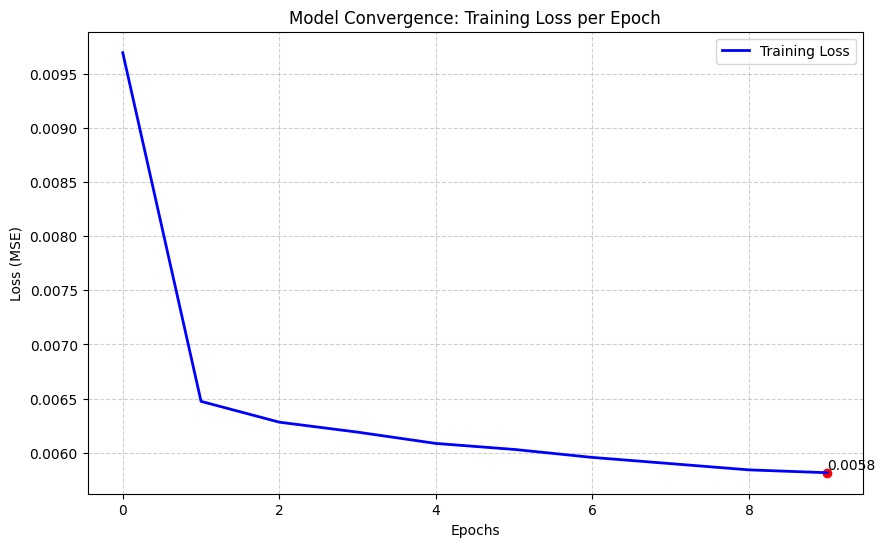

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(epoch_losses, label='Training Loss', color='blue', linewidth=2)

plt.title("Model Convergence: Training Loss per Epoch")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

plt.scatter(len(epoch_losses)-1, epoch_losses[-1], color='red')
plt.text(len(epoch_losses)-1, epoch_losses[-1], f"{epoch_losses[-1]:.4f}", verticalalignment='bottom')

plt.show()

In [22]:
def evaluate_model(model, loader, scalers, device):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for bx, by in loader:
            bx, by = bx.to(device), by.to(device)
            if by.shape[1] == 6 and by.shape[2] == 13:
                by = by.transpose(1, 2)

            pred = model(bx)

            all_preds.append(pred.cpu().numpy())
            all_targets.append(by.cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    feature_names = ['NO2', 'O3', 'CO', 'SO2', 'PM10', 'PM2.5']

    preds_inv = np.zeros_like(preds)
    targets_inv = np.zeros_like(targets)

    for i, feat in enumerate(feature_names):
        scaler = scalers[feat]
        p_slice = preds[:, :, i]
        t_slice = targets[:, :, i]

        preds_inv[:, :, i] = scaler.inverse_transform(p_slice)
        targets_inv[:, :, i] = scaler.inverse_transform(t_slice)

    return preds_inv, targets_inv, feature_names



In [23]:
test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)
y_pred_test, y_true_test, features = evaluate_model(final_model, test_loader, scalers, device)

print("\nModel Performance by Pollutant")
for i, feat in enumerate(features):
    p_flat = y_pred_test[:, :, i].flatten()
    t_flat = y_true_test[:, :, i].flatten()

    mse = mean_squared_error(t_flat, p_flat)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(t_flat, p_flat)
    r2 = r2_score(t_flat, p_flat)

    print(f"{feat:5} | RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")


Model Performance by Pollutant
NO2   | RMSE: 0.0051 | MAE: 0.0037 | R2: 0.8906
O3    | RMSE: 0.0048 | MAE: 0.0032 | R2: 0.8715
CO    | RMSE: 0.0975 | MAE: 0.0682 | R2: 0.8430
SO2   | RMSE: 0.0006 | MAE: 0.0004 | R2: 0.7063
PM10  | RMSE: 9.8684 | MAE: 5.5772 | R2: 0.8357
PM2.5 | RMSE: 6.0140 | MAE: 3.4044 | R2: 0.8269


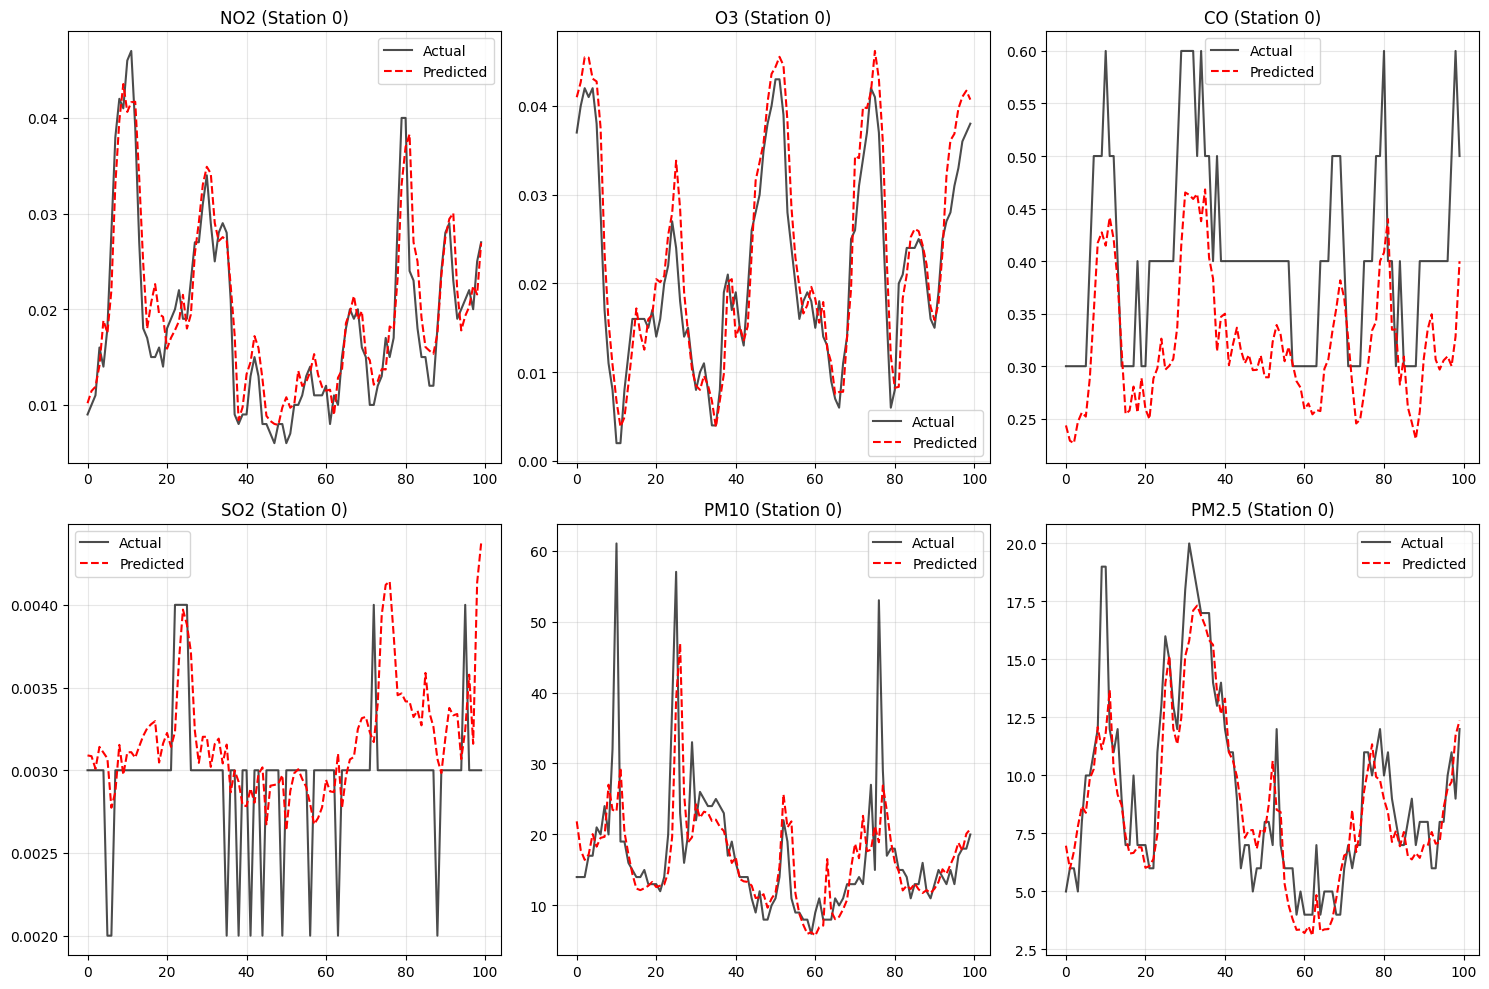

In [24]:
def plot_time_series(y_true, y_pred, feature_names, station_idx=0, samples=100):
    """Plots the first N samples for a specific station"""
    plt.figure(figsize=(15, 10))
    time_steps = range(samples)

    for i, feat in enumerate(feature_names):
        plt.subplot(2, 3, i+1)
        plt.plot(time_steps, y_true[:samples, station_idx, i], label='Actual', color='black', alpha=0.7)
        plt.plot(time_steps, y_pred[:samples, station_idx, i], label='Predicted', color='red', linestyle='--')
        plt.title(f"{feat} (Station {station_idx})")
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Visualize first 100 hours for Station 0 (index 0)
plot_time_series(y_true_test, y_pred_test, features, station_idx=0, samples=100)

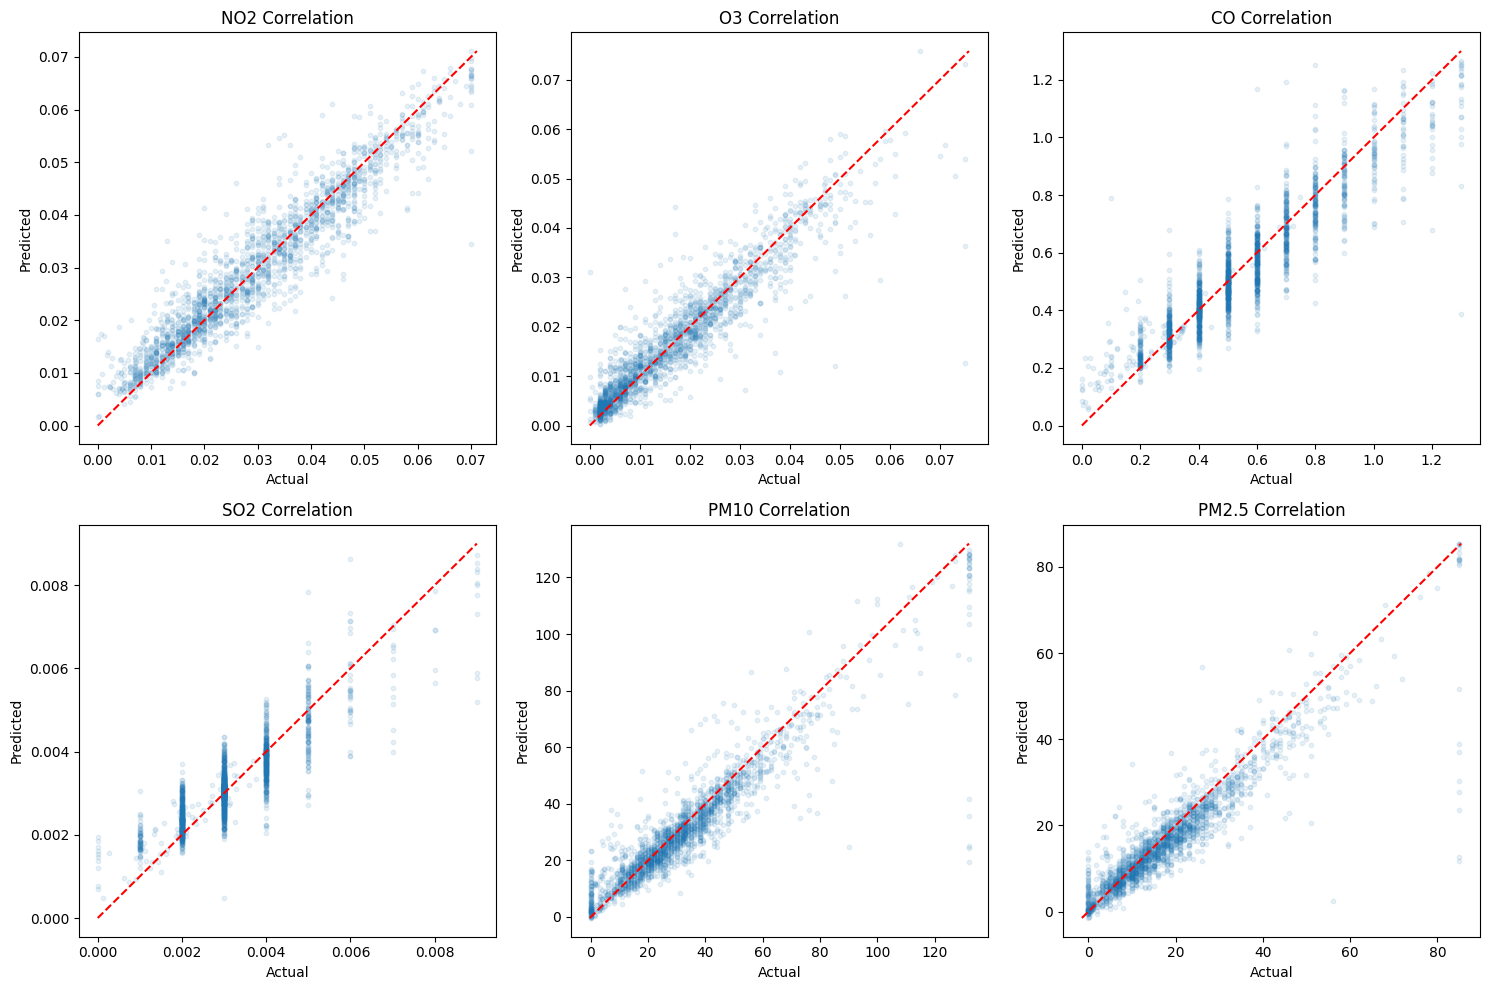

In [25]:
def plot_scatter(y_true, y_pred, feature_names):
    plt.figure(figsize=(15, 10))

    for i, feat in enumerate(feature_names):
        plt.subplot(2, 3, i+1)
        # Sample random points to avoid laggy plots if data is huge
        idx = np.random.choice(y_true.shape[0] * y_true.shape[1], 2000, replace=False)

        flat_t = y_true[:, :, i].flatten()[idx]
        flat_p = y_pred[:, :, i].flatten()[idx]

        plt.scatter(flat_t, flat_p, alpha=0.1, s=10)

        # Perfect prediction line
        min_val, max_val = min(flat_t.min(), flat_p.min()), max(flat_t.max(), flat_p.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')

        plt.title(f"{feat} Correlation")
        plt.xlabel("Actual")
        plt.ylabel("Predicted")

    plt.tight_layout()
    plt.show()

plot_scatter(y_true_test, y_pred_test, features)

In [26]:
def predict_from_csv(csv_path, model, scalers):
    input_df = pd.read_csv(csv_path)
    input_df['Measurement date'] = pd.to_datetime(input_df['Measurement date'])

    keep_stations = [101, 102, 105, 106, 107, 109, 111, 112, 113, 119, 120, 121, 122]
    input_df = input_df[input_df['Station code'].isin(keep_stations)]

    timestamps = np.sort(input_df['Measurement date'].unique())

    if len(timestamps) < 24:
        raise ValueError(f"CSV only has {len(timestamps)} hours of data. Model requires 24 hours history.")

    last_24_hours = timestamps[-24:]
    input_df = input_df[input_df['Measurement date'].isin(last_24_hours)]

    time_df = pd.DataFrame({'Measurement date': last_24_hours})
    time_df['hour'] = time_df['Measurement date'].dt.hour
    time_df['month'] = time_df['Measurement date'].dt.month

    time_feats = {}
    time_feats['hour_sin'] = np.sin(2 * np.pi * time_df['hour'] / 24.0).values
    time_feats['hour_cos'] = np.cos(2 * np.pi * time_df['hour'] / 24.0).values
    time_feats['month_sin'] = np.sin(2 * np.pi * time_df['month'] / 12.0).values
    time_feats['month_cos'] = np.cos(2 * np.pi * time_df['month'] / 12.0).values

    feature_cols = ['NO2', 'O3', 'CO', 'SO2', 'PM10', 'PM2.5']
    time_cols = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']

    processed_features = []

    for feat in feature_cols:
        pivot = input_df.pivot_table(index='Measurement date', columns='Station code', values=feat)
        pivot = pivot.reindex(columns=keep_stations)
        pivot = pivot.interpolate(method='linear', limit_direction='both').bfill().ffill()

        values = pivot.values

        if feat in scalers:
            values_norm = scalers[feat].transform(values)
        else:
            values_norm = values

        processed_features.append(values_norm)

    num_stations = len(keep_stations)
    for t_col in time_cols:
        t_val = time_feats[t_col].reshape(-1, 1)
        t_block = np.tile(t_val, (1, num_stations))
        processed_features.append(t_block)

    input_seq = np.stack(processed_features, axis=-1)
    input_tensor = torch.FloatTensor(input_seq).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor)

    results_dict = {'Station Code': keep_stations}

    for i, feat_name in enumerate(feature_cols):
        pred_norm = prediction[0, :, i].cpu().numpy().reshape(1, -1) # (1, 13)

        if feat_name in scalers:
            pred_actual = scalers[feat_name].inverse_transform(pred_norm)
        else:
            pred_actual = pred_norm

        pred_actual = np.clip(pred_actual, a_min=0.0, a_max=None)

        results_dict[f'Predicted {feat_name}'] = pred_actual.flatten()

    results = pd.DataFrame(results_dict)

    return results

In [27]:
best_params = {'batch_size': 32, 'hidden_dim': 128, 'learning_rate': 0.001, 'dropout': 0.1}

In [ ]:
NUM_NODES = len(keep_stations_codes)
model = TGCN(NUM_NODES, NUM_FEATURES, best_params['hidden_dim'], TARGET_DIM, adj_matrix, best_params['dropout']).to(device)

model.load_state_dict(torch.load('best_tuned_model.pth'))
# scalers = joblib.load("seoul_scalers.pkl")

try:
    forecast_df = predict_from_csv('/content/aqi_data_sorted.csv', model, scalers)
    print("\n--- Forecast for Next Hour (All Pollutants) ---")

    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(forecast_df.round(4))

except Exception as e:
    print(f"Error during prediction: {e}")

Error during prediction: [Errno 2] No such file or directory: '/content/aqi_data_sorted.csv'
